Código para Dataset de Circulación

In [3]:
# Importamos librerias:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Leemos el primer dataset
# Descargado de https://covid19.apple.com/mobility
data = pd.read_csv("/content/applemobilitytrends-2021-07-23.csv", sep=",")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Nos quedamos con las series de Argentina, serie_d = driving, serie_w = walking
data=data[data["region"]=="Argentina"]
dates = data.columns[6:]
data_d = data[data["transportation_type"]=="driving"]
data_w = data[data["transportation_type"]=="walking"]
serie_d=pd.DataFrame(data=data_d.iloc[0:,6:].transpose())
serie_w=pd.DataFrame(data=data_w.iloc[0:,6:].transpose())
serie_d = serie_d.rename(columns={2: 'Value'})
serie_w = serie_d.rename(columns={3: 'Value'})
serie_d.index = pd.to_datetime(serie_d.index)
serie_w.index = pd.to_datetime(serie_w.index)

In [6]:
# Interpolamos valores faltantes:
serie_d=serie_d.interpolate()
serie_w=serie_w.interpolate()


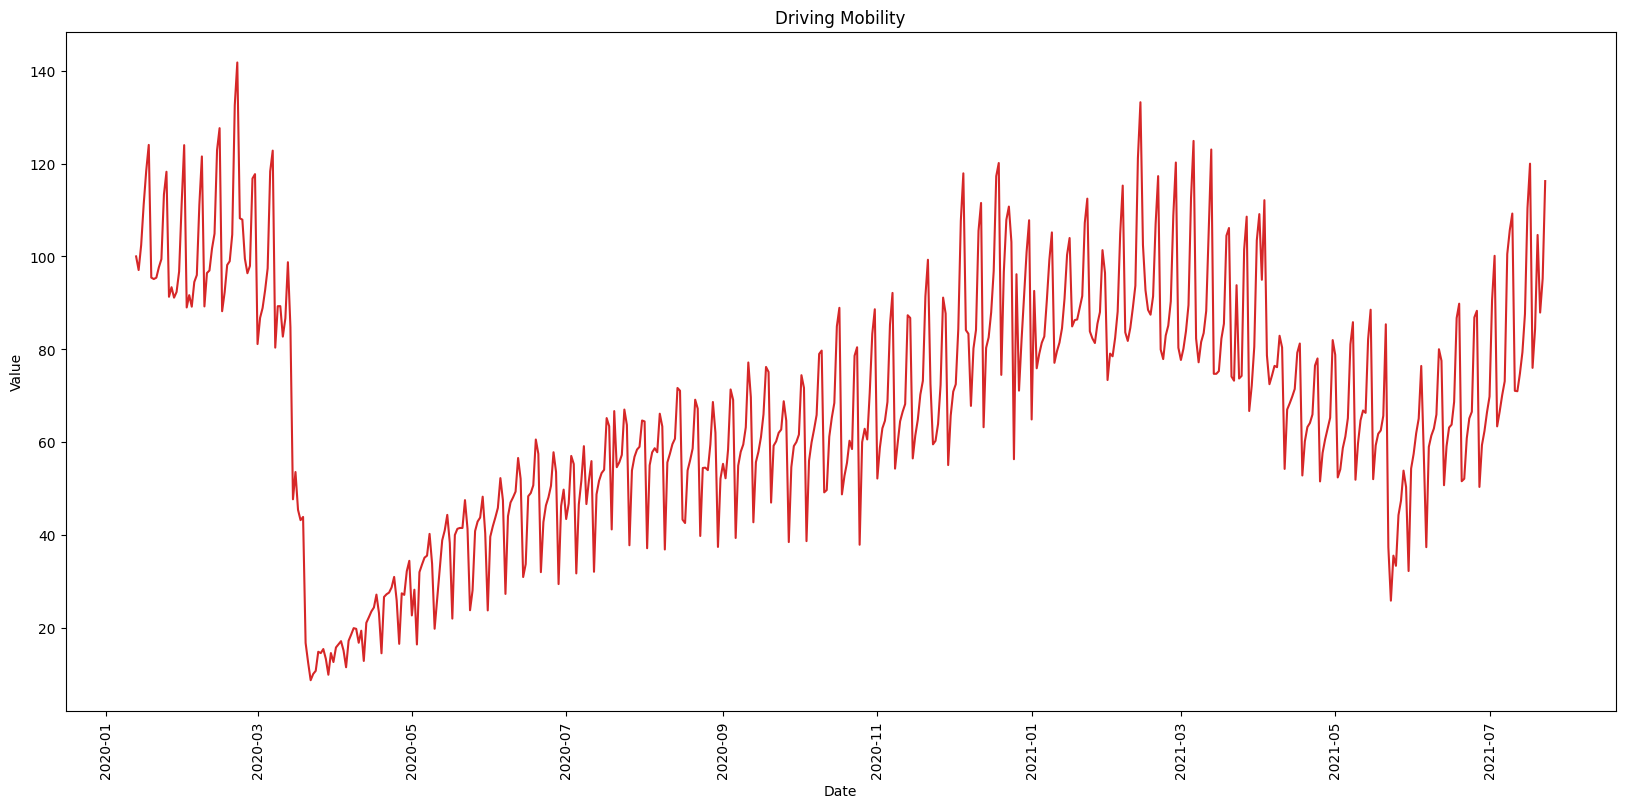

In [7]:
# Gráfico Driving
def plot_data(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,9), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.savefig("Image.png")
    plt.show()
plot_data(serie_d, x=serie_d.index, y=serie_d.Value, title='Driving Mobility')

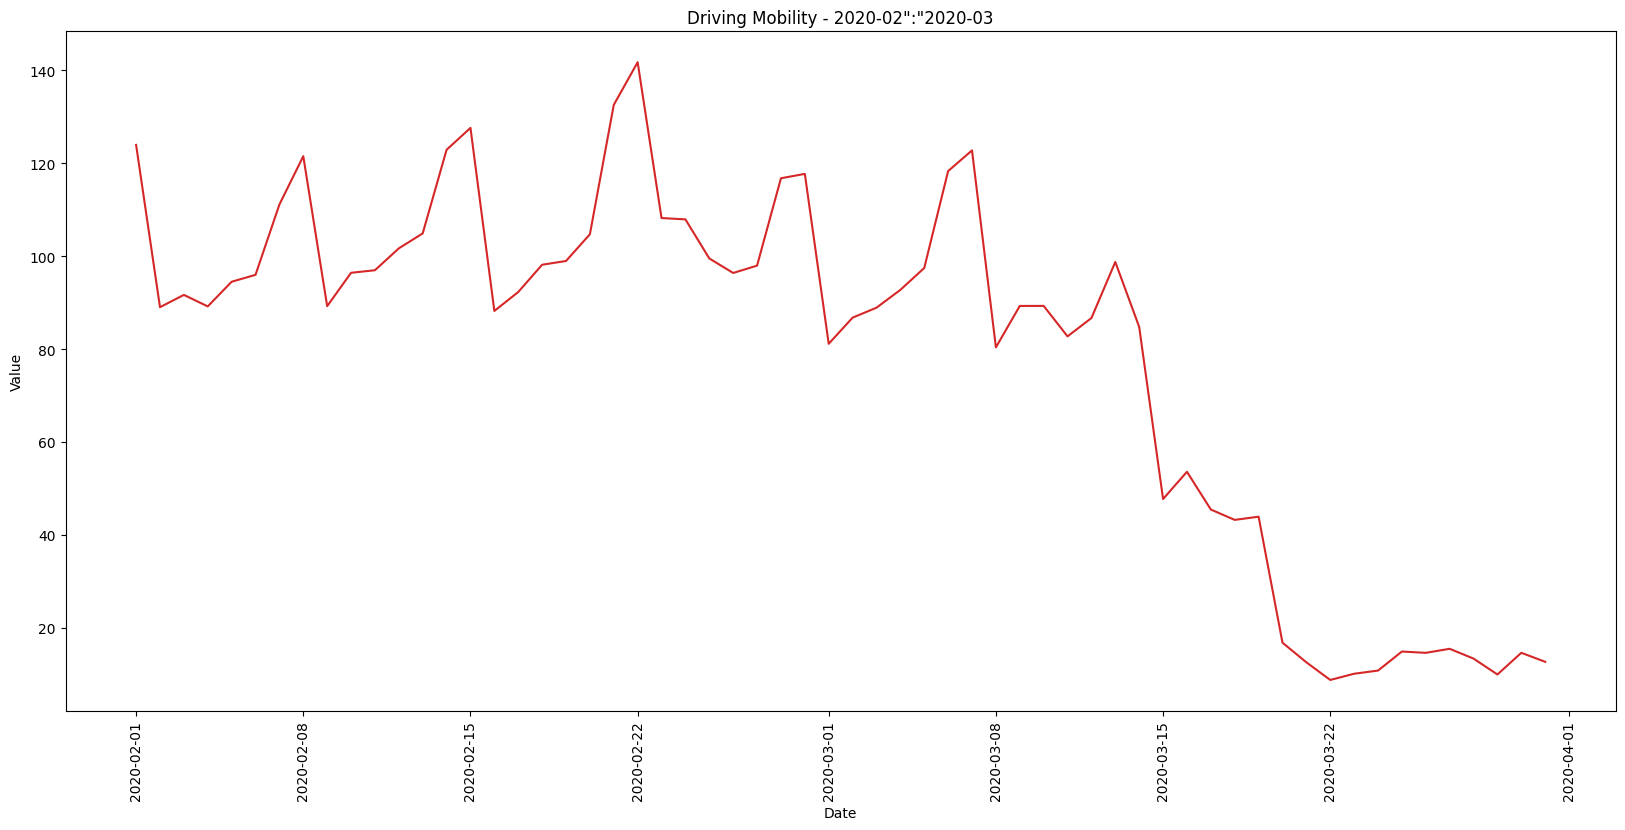

In [8]:
# Zoom sobre la fecha de la primer caida:
plot_data(serie_d.loc["2020-02-01":"2020-03-31"], x=serie_d.loc["2020-02-01":"2020-03-31"].index, y=serie_d.loc["2020-02-01":"2020-03-31"].Value, title='Driving Mobility - 2020-02":"2020-03')

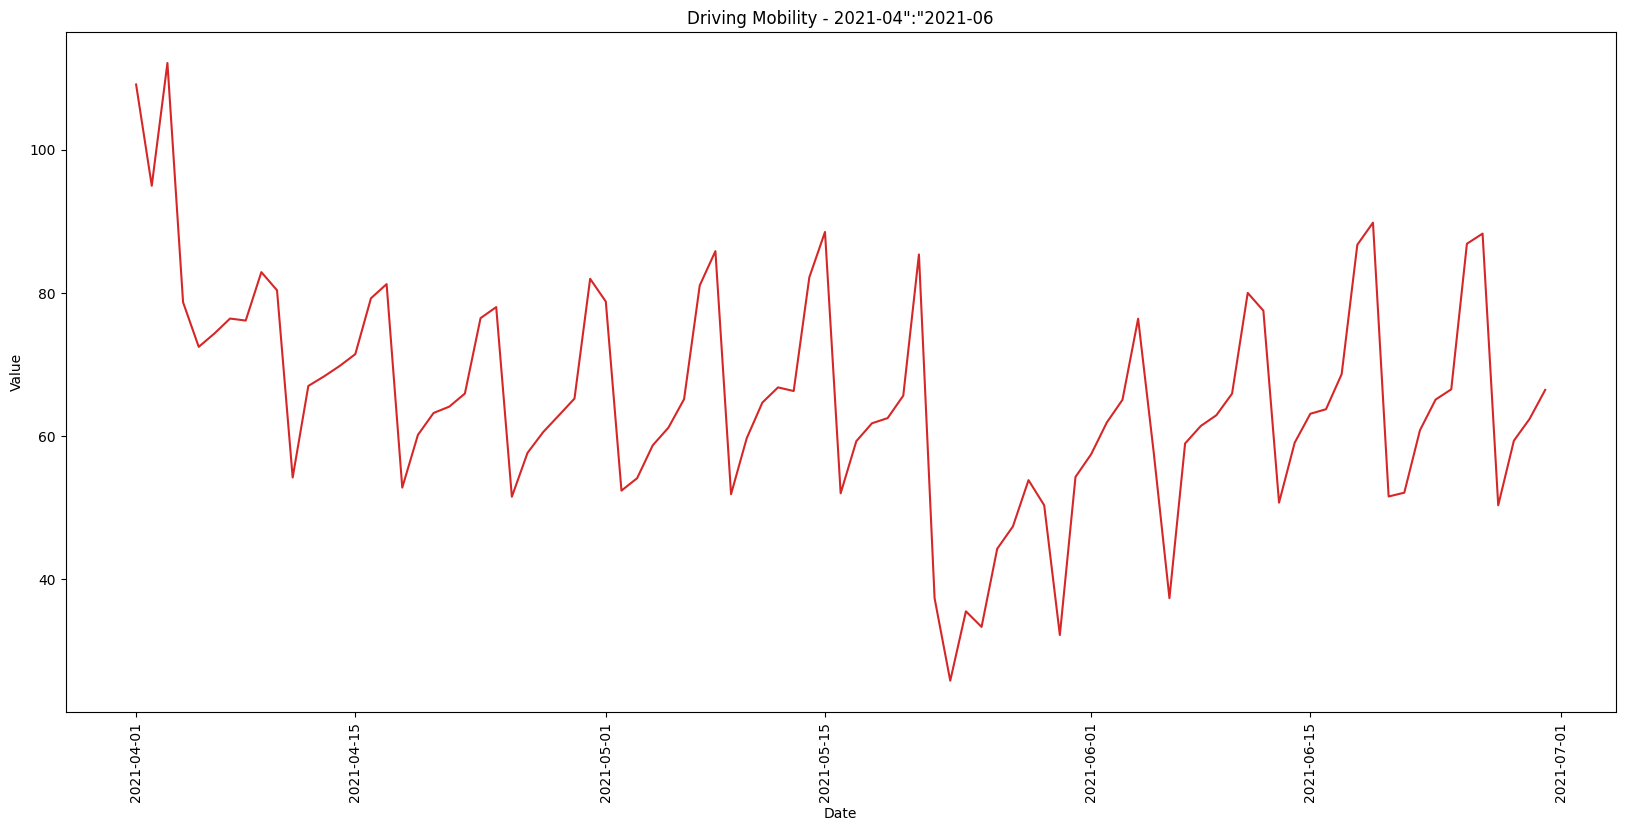

In [9]:
# Zoom sobre la fecha de la segunda caida:
plot_data(serie_d.loc["2021-04-01":"2021-06-30"], x=serie_d.loc["2021-04-01":"2021-06-30"].index, y=serie_d.loc["2021-04-01":"2021-06-30"].Value, title='Driving Mobility - 2021-04":"2021-06')

In [10]:
# Agregamos días de la semana:
serie_d['Weekday'] = pd.DatetimeIndex(serie_d.index).to_series().dt.day_name()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


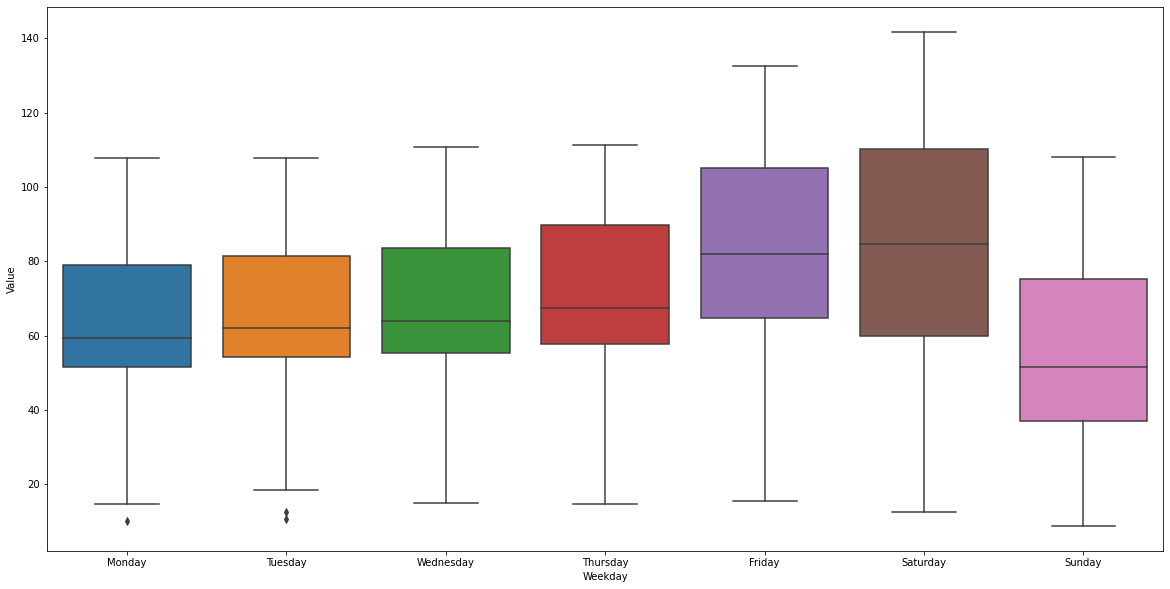

In [11]:
# Graficamos boxplot:
import seaborn
fig, ax = plt.subplots(figsize=(20,10))
seaborn.boxplot(serie_d.Weekday, serie_d.Value, ax=ax)
plt.savefig("boxplot.png")

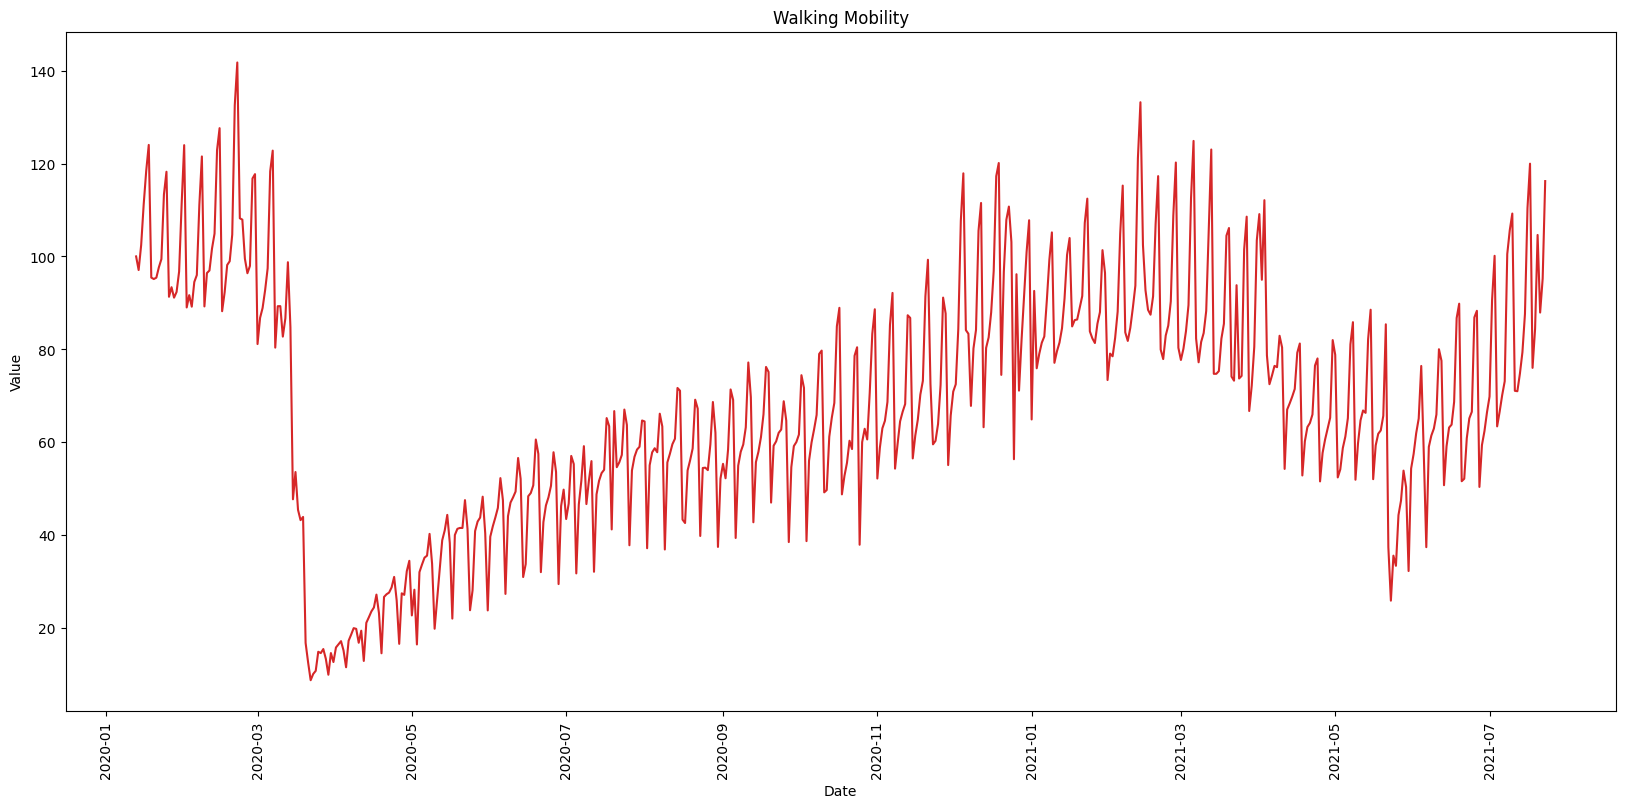

In [12]:
# Gráficamos Walking
def plot_data(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,9), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.savefig("Image.png")
    plt.show()
plot_data(serie_w, x=serie_w.index, y=serie_w.Value, title='Walking Mobility')

In [13]:
# Vemos que el comportamiento es similar a driving, por lo tanto vamos a seguir trabajando con la serie driving.

In [14]:
# Conviertimos en array para realizar tests de estacionariedad
serie_d = serie_d.drop(labels="Weekday", axis=1)
serie_d_array = serie_d.loc[:, 'Value'].values

In [15]:
# Test KPSS para driving:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, regression="c")
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(serie_d_array)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


KPSS Statistic: 0.5197304984653354
p-value: 0.03722286070600555
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


In [16]:
# Test ADF:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')   

In [17]:
adf_test(serie_d_array)

ADF Statistic: -2.3374375301027768
p-value: 0.16017767398672472
Critial Values:
   1%, -3.442563336759378
Critial Values:
   5%, -2.866927190004947
Critial Values:
   10%, -2.5696391843672695
Result: The series is not stationary


In [18]:
# Instalo librerias:
!pip install chart-studio

     |████████████████████████████████| 64 kB 2.3 MB/s 


In [19]:
from chart_studio import plotly
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
import plotly.express as px

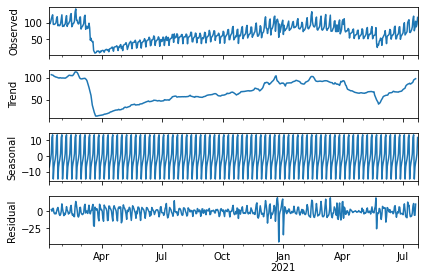

In [21]:
# Graficamos descomposición de serie:
result = seasonal_decompose(serie_d, model="additive")
fig = result.plot()
plt.savefig("Image.png")
plt.show(fig)

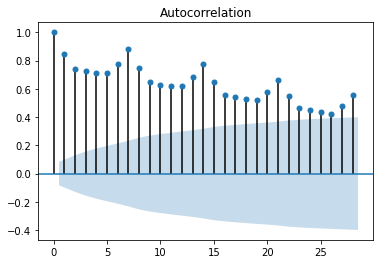

In [22]:
# Gráfico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_d)
plt.savefig("Image 1.f.png")
plt.show()

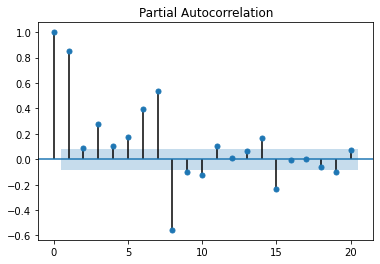

In [23]:
# Gráfico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie_d, lags=20)
plt.savefig("Image 1g.png")
plt.show()

In [24]:
# Realizamos test Ljung-Box con lag=20
import statsmodels.api as sm
sm.stats.acorr_ljungbox(serie_d, lags=20)

# P valor para todos los lags es meor a 0,05, por lo tanto rejecteamos la H0 -> Hay al menos una correlacion distinta de 0

(array([ 402.57076618,  712.66838037, 1008.848006  , 1293.34672216,
        1577.42369536, 1920.48075015, 2359.53017535, 2678.10821719,
        2919.52940694, 3145.56504135, 3364.50278554, 3585.47749032,
        3850.9335639 , 4193.8997819 , 4436.47542737, 4615.02878996,
        4784.95253467, 4945.84795533, 5103.10706812, 5295.8091509 ]),
 array([1.51815319e-089, 1.76208757e-155, 2.16631565e-218, 9.21899809e-279,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [25]:
# Diferenciamos la serie:

serie_d_dif=serie_d
serie_d_dif["Diferences"] = None


In [26]:
for i in range(0,(serie_d_dif.shape[0]-1)):
  serie_d_dif.iloc[(i+1),1]=serie_d_dif.iloc[(i+1),0] - serie_d_dif.iloc[i,0]

In [27]:
serie_d_dif.head()

,Value,Diferences
2020-01-13,100.00,None
2020-01-14,97.07,-2.93
2020-01-15,102.45,5.38
2020-01-16,111.21,8.76
2020-01-17,118.45,7.24


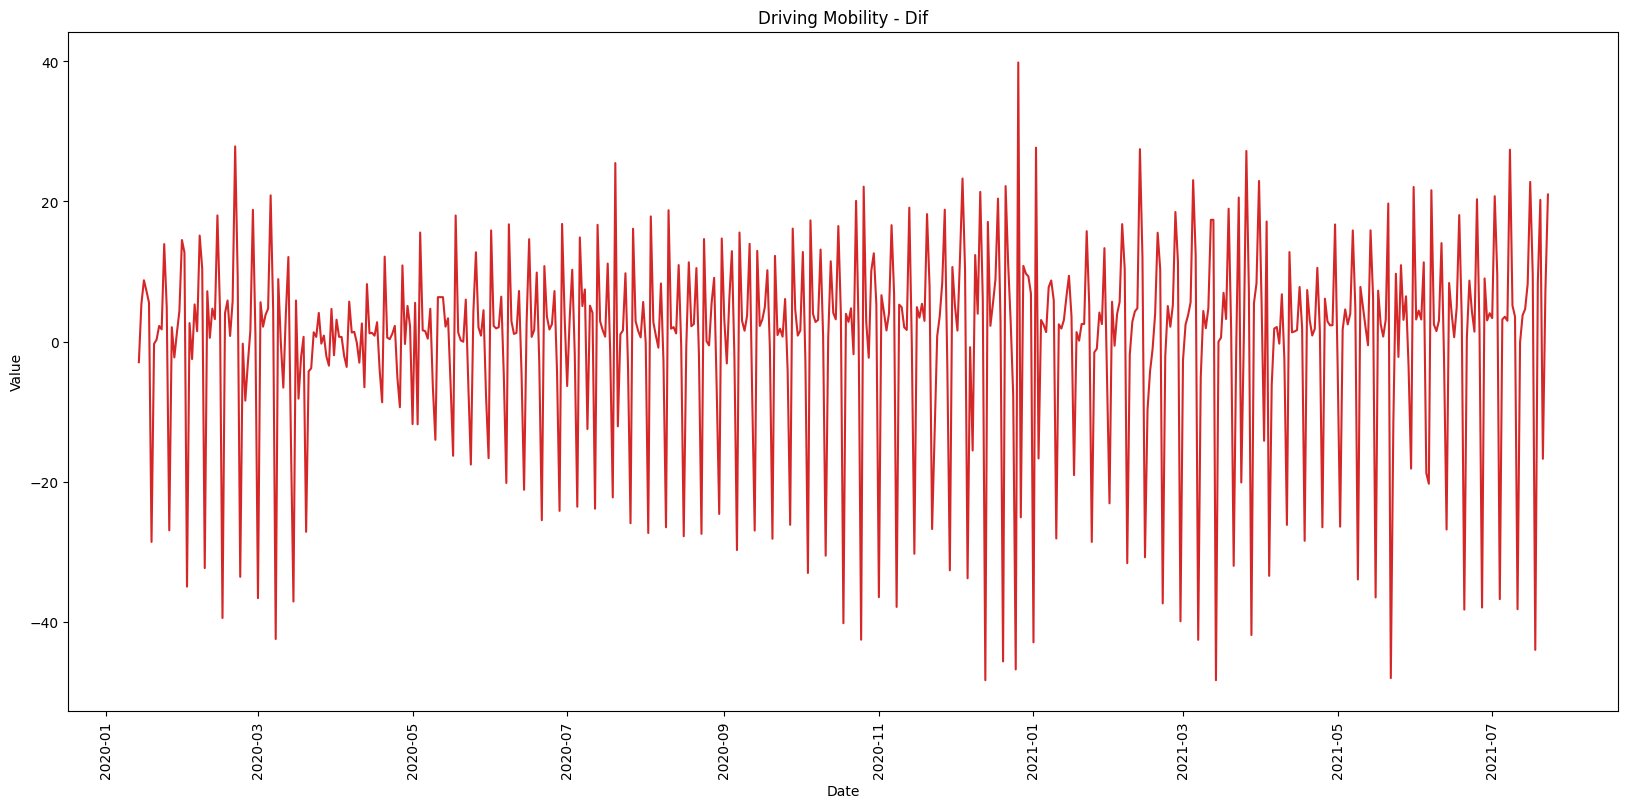

In [28]:
# Graficamos la serie diferenciada:
plot_data(serie_d_dif, x=serie_d_dif.index, y=serie_d_dif.Diferences, title='Driving Mobility - Dif')

In [29]:
# Convertimos en array para realizar tests de estacionariedad
serie_d_dif_array = serie_d_dif.iloc[1:, 1].values

In [30]:
# Test KPSS
kpss_test(serie_d_dif_array)

KPSS Statistic: 0.14218559201242406
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



In [31]:
# Test ADF
adf_test(serie_d_dif_array)

ADF Statistic: -5.465193482171026
p-value: 2.4678154120290828e-06
Critial Values:
   1%, -3.4425861905056556
Critial Values:
   5%, -2.8669372502674824
Critial Values:
   10%, -2.5696445454608505
Result: The series is stationary


In [32]:
serie_d_dif=serie_d_dif["Diferences"].iloc[1:]
serie_d_dif=pd.DataFrame(serie_d_dif)

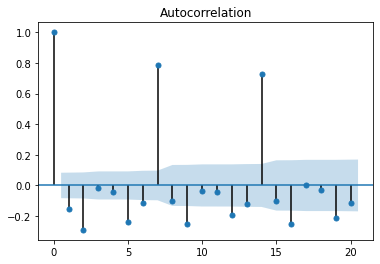

In [33]:
# Grafico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_d_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 3.b.png")
plt.show()

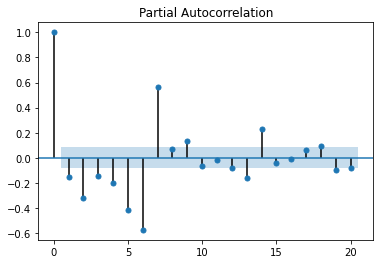

In [34]:
# Grafico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie_d_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 3.c.png")
plt.show()

In [35]:
# Test de Ljung Box:
sm.stats.acorr_ljungbox(serie_d_dif.Diferences.tolist(), lags=20)

(array([ 13.28769833,  60.55218334,  60.72106833,  61.64452195,
         92.91087696, 100.74291523, 450.0951725 , 456.16352528,
        492.35045195, 493.0892867 , 494.26261805, 515.35384602,
        523.59697849, 826.01876383, 831.82819381, 868.81810772,
        868.82448163, 869.39500118, 894.7741143 , 902.31780684]),
 array([2.67153254e-004, 7.10003444e-014, 4.12269063e-013, 1.30855859e-012,
        1.64257051e-018, 1.75603120e-019, 4.23657172e-093, 1.76682794e-093,
        2.49667515e-100, 1.32271870e-099, 5.36416821e-099, 1.19400684e-102,
        1.41626838e-103, 2.99965503e-167, 1.34591524e-167, 1.28364563e-174,
        9.58910190e-174, 5.26379383e-173, 1.46142793e-177, 2.52413047e-178]))

In [36]:
#Instalamos otras librerias:
import statsmodels.api

In [37]:
!pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.5 MB 14.1 MB/s 
     |████████████████████████████████| 9.5 MB 49.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [38]:
!pip install statsmodels

In [39]:

# Hacemos busqueda del mejor modelo SARIMA:
stepwise_fit = pm.auto_arima(serie_d.Value, start_p=1, start_q=1, max_p=10, max_q=10, m=7,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=3811.001, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3999.509, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=3902.428, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=3834.637, Time=0.31 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.29 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=3794.902, Time=1.72 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=4.61 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=3821.186, Time=1.04 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=3837.110, Time=1.25 sec
 ARIMA(2,1,1)(0,1,2)[7]             : AIC=3792.465, Time=2.62 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=3805.942, Time=0.82 sec
 ARIMA(2,1,1)(1,1,2)[7]             : AIC=inf, Time=5.71 sec
 ARIMA(2,1,1)(1,1,1)[7]             : AIC=inf, Time=2.04 sec
 ARIMA(2,1,0)(0,1,2)[7]             : AIC=3802.258, Time=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  558
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -1888.866
Date:                           Sun, 01 Aug 2021   AIC                           3787.732
Time:                                   00:57:25   BIC                           3809.282
Sample:                                        0   HQIC                          3796.154
                                           - 558                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2522      0.030     -8.396      0.000      -0.311      -0.193
ma.L2         -0.2744      0.036     -7.684      0.000      -0.344      -0.204
ma.S.L7       -0.6099      0.023    -26.950      0.000      -0.654      -0.566
ma.S.L14      -0.1994      0.027     -7.293      0.000      -0.253      -0.146
sigma2        55.5897      1.182     47.023      0.000      53.273      57.907
===================================================================================
Ljung-Box (Q):                       45.71   Jarque-Bera (JB):              8414.76
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -2.37
Prob(H) (two-sided):                  0.02   Kurtosis:                        21.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
serie_d=serie_d.drop("Diferences", axis=1)

In [41]:
# Dividimos en train y test:
train = serie_d.loc['2020-01-13':'2021-03-31']
test = serie_d.loc['2021-04-01':'2021-07-23']

In [42]:
# Entrenamos:
stepwise_fit.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 2, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [43]:
# Predecimos:
future_forecast = stepwise_fit.predict(n_periods=len(test))


In [44]:
print(future_forecast)

[ 99.91628251 112.2883049  121.54376371  82.49791812  84.85600932
  89.77851048 102.12576452 102.86864172 117.24207921 126.25856186
  89.27456822  90.1353022   95.60568499 100.61521804 102.88704342
 119.25139628 128.26787893  91.28388529  92.14461927  97.61500206
 102.62453511 104.8963605  121.26071335 130.277196    93.29320236
  94.15393634  99.62431913 104.63385218 106.90567757 123.27003042
 132.28651307  95.30251944  96.16325341 101.6336362  106.64316925
 108.91499464 125.27934749 134.29583014  97.31183651  98.17257048
 103.64295328 108.65248632 110.92431171 127.28866456 136.30514721
  99.32115358 100.18188755 105.65227035 110.66180339 112.93362878
 129.29798163 138.31446428 101.33047065 102.19120463 107.66158742
 112.67112046 114.94294585 131.3072987  140.32378135 103.33978772
 104.2005217  109.67090449 114.68043753 116.95226292 133.31661578
 142.33309842 105.34910479 106.20983877 111.68022156 116.6897546
 118.96157999 135.32593285 144.34241549 107.35842186 108.21915584
 113.689538

In [45]:
# Graficamos la comparación:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
comparison = pd.concat([test,future_forecast],axis=1)

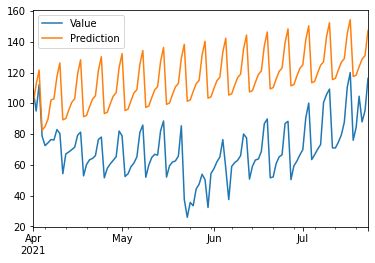

In [46]:
comparison.plot()
plt.savefig("Model 1.a.png")

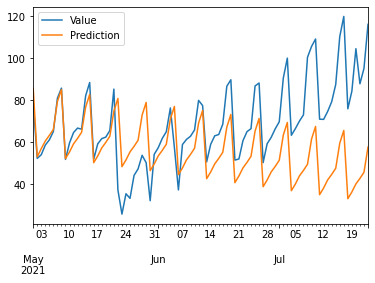

In [47]:
# HAcemos lo mismo para otros periodos de train y test:
train = serie_d.loc['2020-01-13':'2021-04-30']
test = serie_d.loc['2021-05-01':'2021-07-23']
stepwise_fit.fit(train)
future_forecast_2 = stepwise_fit.predict(n_periods=len(test))
future_forecast_2 = pd.DataFrame(future_forecast_2,index = test.index,columns=["Prediction"])
comparison_2 = pd.concat([test,future_forecast_2],axis=1)
comparison_2.plot()
plt.savefig("Model 1.b.png")

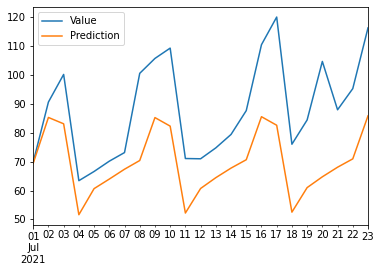

In [48]:
# HAcemos lo mismo para otros periodos de train y test:
train = serie_d.loc['2020-01-13':'2021-06-30']
test = serie_d.loc['2021-07-01':'2021-07-23']
stepwise_fit.fit(train)
future_forecast_2 = stepwise_fit.predict(n_periods=len(test))
future_forecast_2 = pd.DataFrame(future_forecast_2,index = test.index,columns=["Prediction"])
comparison_2 = pd.concat([test,future_forecast_2],axis=1)
comparison_2.plot()
plt.savefig("Model 1.c.png")

In [49]:
# Ampliamos la busqueda del modelo:
stepwise_fit_2 = pm.auto_arima(serie_d.Value, start_p=1, start_q=1, max_p=10, max_q=10, m=7,
                             start_P=0,max_P=10, seasonal=True, d=1, D=1, max_D=10, max_d=10, start_Q=1, max_Q=10, trace=True, with_intercept=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True,
                             maxiter=100)  # set to stepwise

stepwise_fit_2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7] intercept   : AIC=3812.897, Time=1.23 sec
 ARIMA(0,1,0)(0,1,0)[7] intercept   : AIC=4001.507, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7] intercept   : AIC=3904.423, Time=0.56 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=3836.600, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3999.509, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[7] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,1,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(1,1,1)(0,1,2)[7] intercept   : AIC=3796.569, Time=4.51 sec
 ARIMA(1,1,1)(1,1,2)[7] intercept   : AIC=inf, Time=8.94 sec
 ARIMA(1,1,1)(0,1,3)[7] intercept   : AIC=3791.936, Time=9.16 sec
 ARIMA(1,1,1)(1,1,3)[7] intercept   : AIC=inf, Time=23.20 sec
 ARIMA(1,1,1)(0,1,4)[7] intercept   : AIC=inf, Time=13.07 sec
 ARIMA(1,1,1)(1,1,4)[7] intercept   : AIC=inf, Time=22.06 sec
 ARIMA(0,1,1)(0,1,3)[7] intercept   : AIC=3819.232, Time=4.65 sec
 ARIMA(1,1,0)(0,1,3)[7] intercept   : AIC=3835.738, Time=3.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  558
Model:             SARIMAX(0, 1, 2)x(0, 1, 3, 7)   Log Likelihood               -1885.029
Date:                           Sun, 01 Aug 2021   AIC                           3782.059
Time:                                   01:10:59   BIC                           3807.918
Sample:                                        0   HQIC                          3792.164
                                           - 558                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2490      0.029     -8.550      0.000      -0.306      -0.192
ma.L2         -0.2801      0.036     -7.713      0.000      -0.351      -0.209
ma.S.L7       -0.6330      0.024    -26.633      0.000      -0.680      -0.586
ma.S.L14      -0.1162      0.036     -3.261      0.001      -0.186      -0.046
ma.S.L21      -0.1325      0.032     -4.188      0.000      -0.194      -0.070
sigma2        54.5749      1.420     38.436      0.000      51.792      57.358
===================================================================================
Ljung-Box (Q):                       45.87   Jarque-Bera (JB):              8076.09
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -2.32
Prob(H) (two-sided):                  0.03   Kurtosis:                        21.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

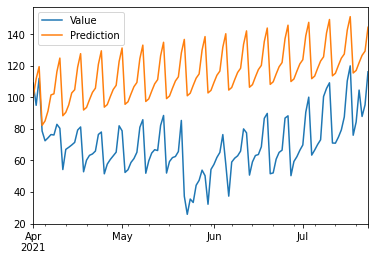

In [50]:
# Entrenamos, testeamos y graficamos:
train = serie_d.loc['2020-01-13':'2021-03-31']
test = serie_d.loc['2021-04-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast_3 = stepwise_fit_2.predict(n_periods=len(test))
future_forecast_3 = pd.DataFrame(future_forecast_3,index = test.index,columns=["Prediction"])
comparison_3 = pd.concat([test,future_forecast_3],axis=1)
comparison_3.plot()
plt.savefig("Model 2.a.png")

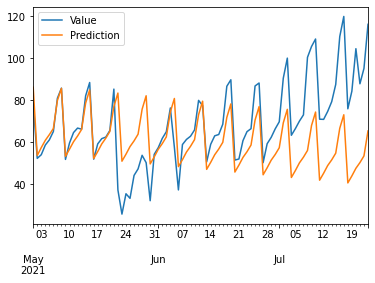

In [51]:
# Entrenamos, testeamos y graficamos para otros periodos:
train = serie_d.loc['2020-01-13':'2021-04-30']
test = serie_d.loc['2021-05-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast_3 = stepwise_fit_2.predict(n_periods=len(test))
future_forecast_3 = pd.DataFrame(future_forecast_3,index = test.index,columns=["Prediction"])
comparison_3 = pd.concat([test,future_forecast_3],axis=1)
comparison_3.plot()
plt.savefig("Model 2.b.png")

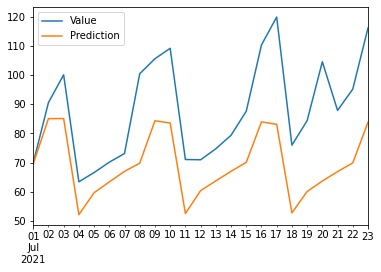

In [52]:
# Entrenamos, testeamos y graficamos para otros periodos:
train = serie_d.loc['2020-01-13':'2021-06-30']
test = serie_d.loc['2021-07-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast_4 = stepwise_fit_2.predict(n_periods=len(test))
future_forecast_4 = pd.DataFrame(future_forecast_4,index = test.index,columns=["Prediction"])
comparison_4 = pd.concat([test,future_forecast_4],axis=1)
comparison_4.plot()
plt.savefig("Model 2.c.png")

In [53]:
ord = (1, 1, 2)
seasonal_ord = (1, 1, 3, 7)

In [54]:
# Probamos otro modelo con p > 0 pero no funciona mejor:
sarima_m = pm.arima.arima.ARIMA(maxiter=100, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=(2, 1, 3, 7), start_params=None, suppress_warnings=True, trend="t", with_intercept=False)

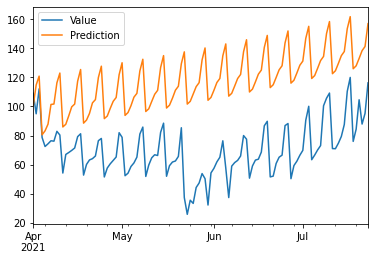

In [55]:
train = serie_d.loc['2020-01-13':'2021-03-31']
test = serie_d.loc['2021-04-01':'2021-07-23']
sarima_m.fit(train)
future_forecast_4 = sarima_m.predict(n_periods=len(test))
future_forecast_4 = pd.DataFrame(future_forecast_4,index = test.index,columns=["Prediction"])
comparison_4 = pd.concat([test,future_forecast_4],axis=1)
comparison_4.plot()
plt.savefig("Model 2.c.png")

In [56]:
dates_predict = pd.date_range("2021-07-24","2021-08-22",freq='d')

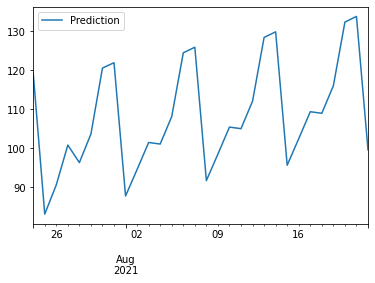

In [57]:
# Predicción:
train = serie_d.loc['2020-01-13':'2021-07-23']
stepwise_fit.fit(train)
future_forecast_2 = stepwise_fit.predict(n_periods=30)
future_forecast_2 = pd.DataFrame(future_forecast_2,index = dates_predict, columns=["Prediction"])
future_forecast_2.plot()
plt.savefig("Prediccion Mobilidad.png")

In [58]:
future_forecast_2.to_csv("/content/sample_data/prediccion_mobilidad.csv")

Codigo para dataset Casos - Covid

In [59]:
# Leemos el dataset
# Descargado de: https://ourworldindata.org/coronavirus/country/argentina
data = pd.read_csv("/content/owid-covid-data.csv", sep=",")

In [60]:
#Limpiamos los datos:
data.index= data.date
data = data[data["location"]== "Argentina"]
serie = data.new_cases
serie= serie.fillna(0)
serie = pd.DataFrame(serie)
serie.index = pd.to_datetime(serie.index)

In [61]:
serie.head()

,new_cases
date,
2020-01-01,0.0
2020-01-02,0.0
2020-01-03,0.0
2020-01-04,0.0
2020-01-05,0.0


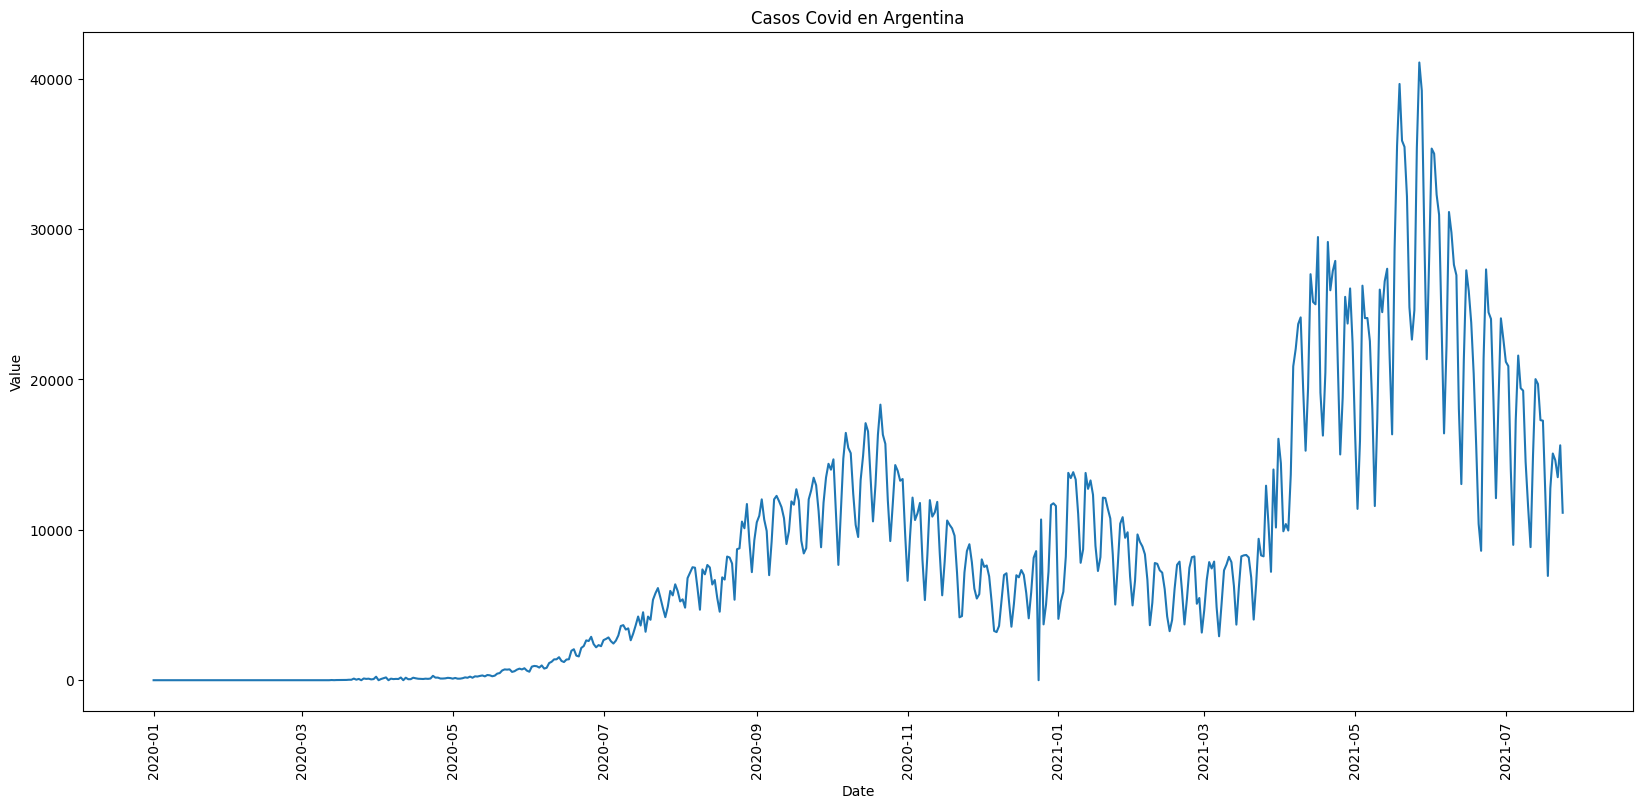

In [62]:
# Gráfico Casos Covid
def plot_data(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,9), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.savefig("Image.png")
    plt.show()
plot_data(serie, x=serie.index, y=serie.new_cases, title='Casos Covid en Argentina')

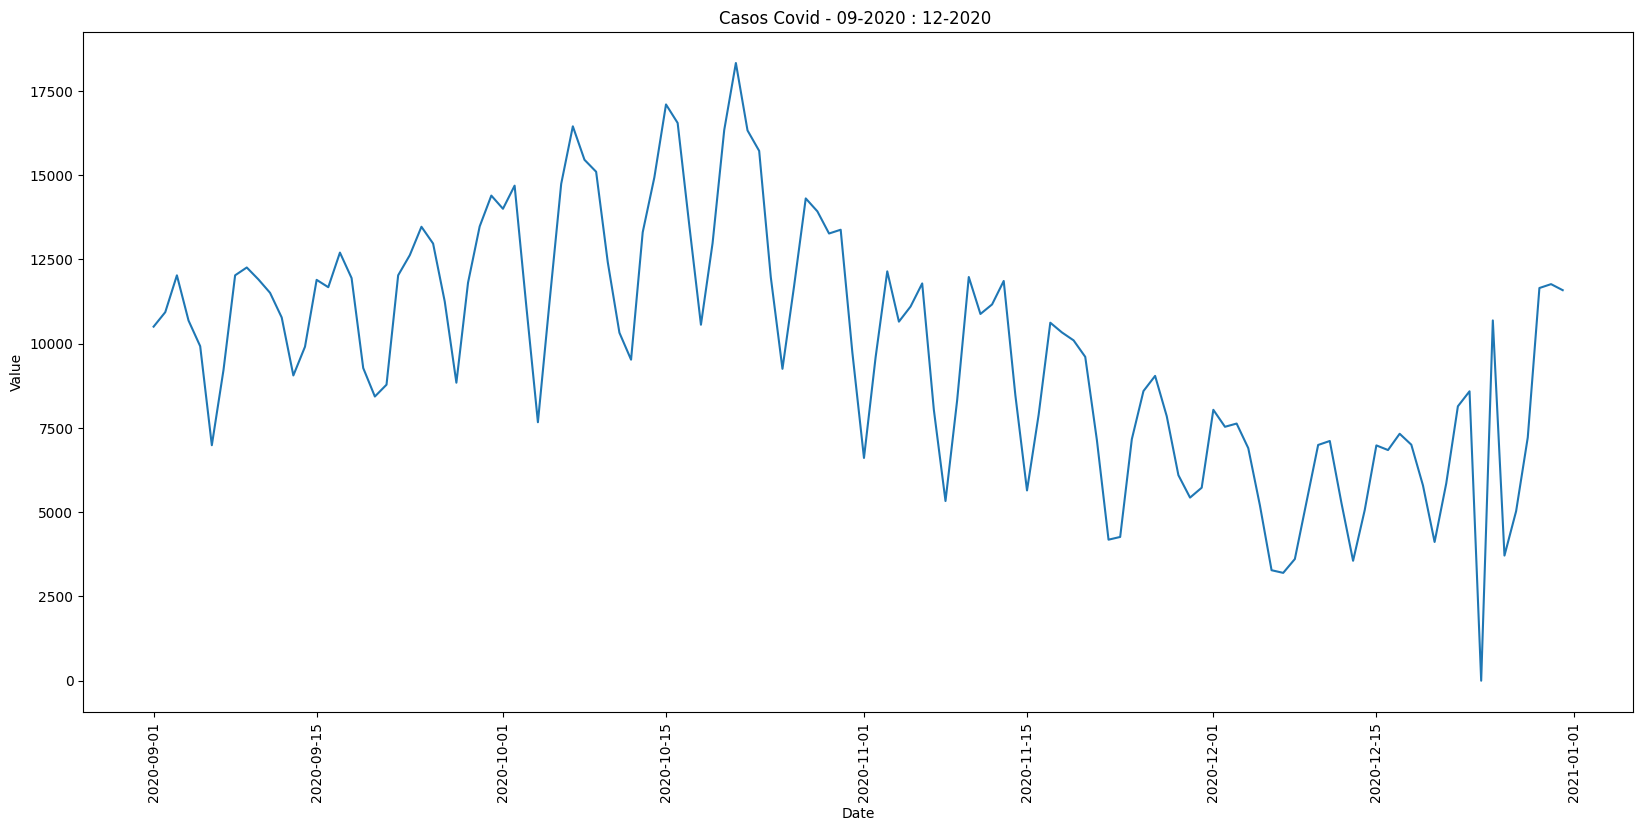

In [63]:
# Zoom sobre el primer ciclo de disminución:
plot_data(serie.loc["2020-09-01":"2020-12-31"], x=serie.loc["2020-09-01":"2020-12-31"].index, y=serie.loc["2020-09-01":"2020-12-31"].new_cases, title='Casos Covid - 09-2020 : 12-2020 ')

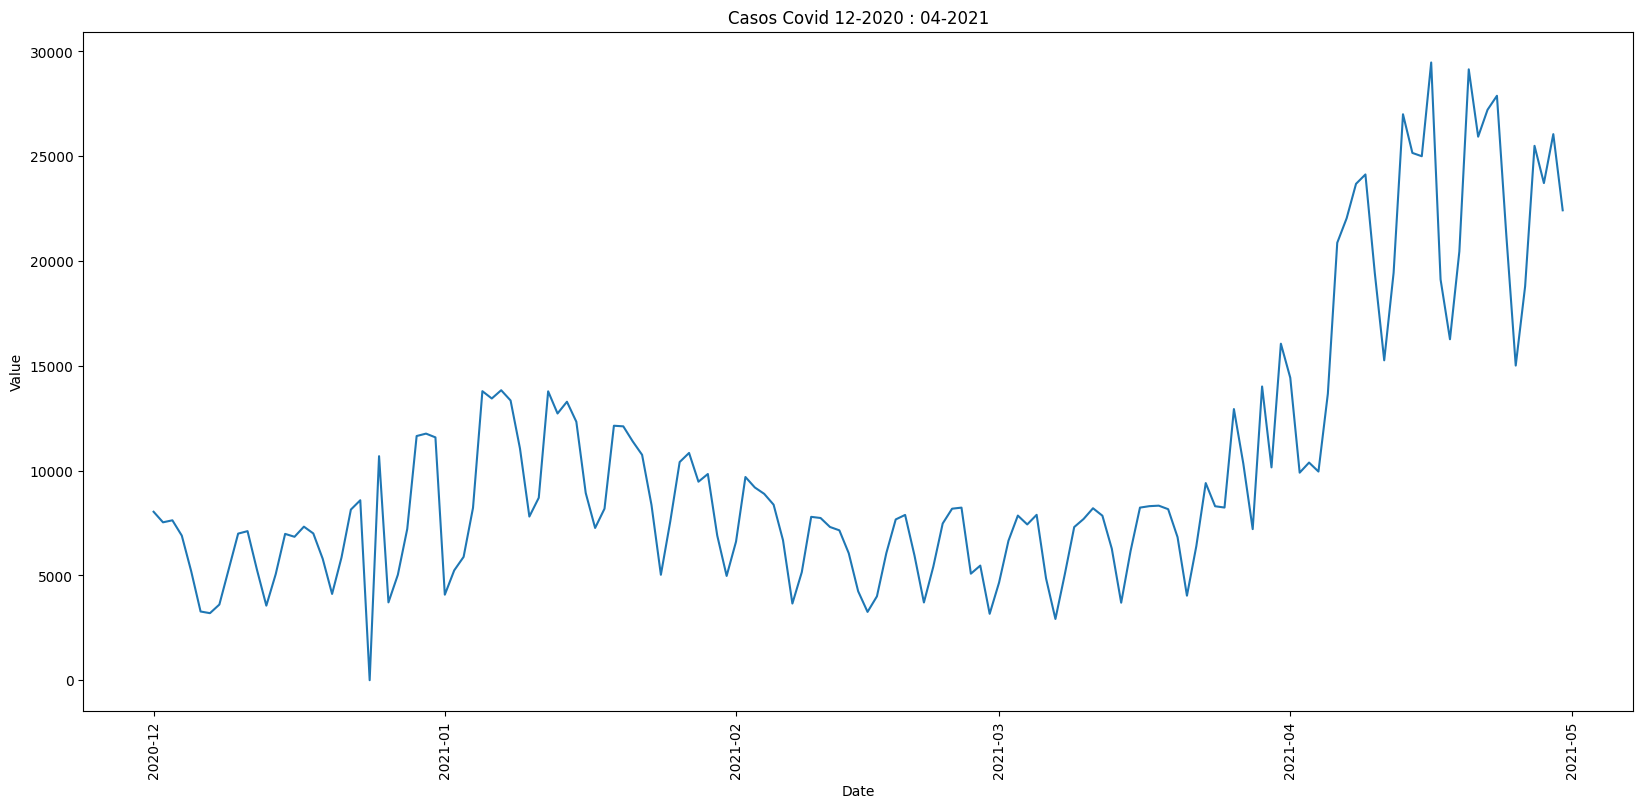

In [64]:
# Zoom sobre segundo ciclo:
plot_data(serie.loc["2020-12-01":"2021-04-30"], x=serie.loc["2020-12-01":"2021-04-30"].index, y=serie.loc["2020-12-01":"2021-04-30"].new_cases, title='Casos Covid 12-2020 : 04-2021')

In [65]:
#Agregamos días de la semana:
serie['Weekday'] = pd.DatetimeIndex(serie.index).to_series().dt.day_name()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



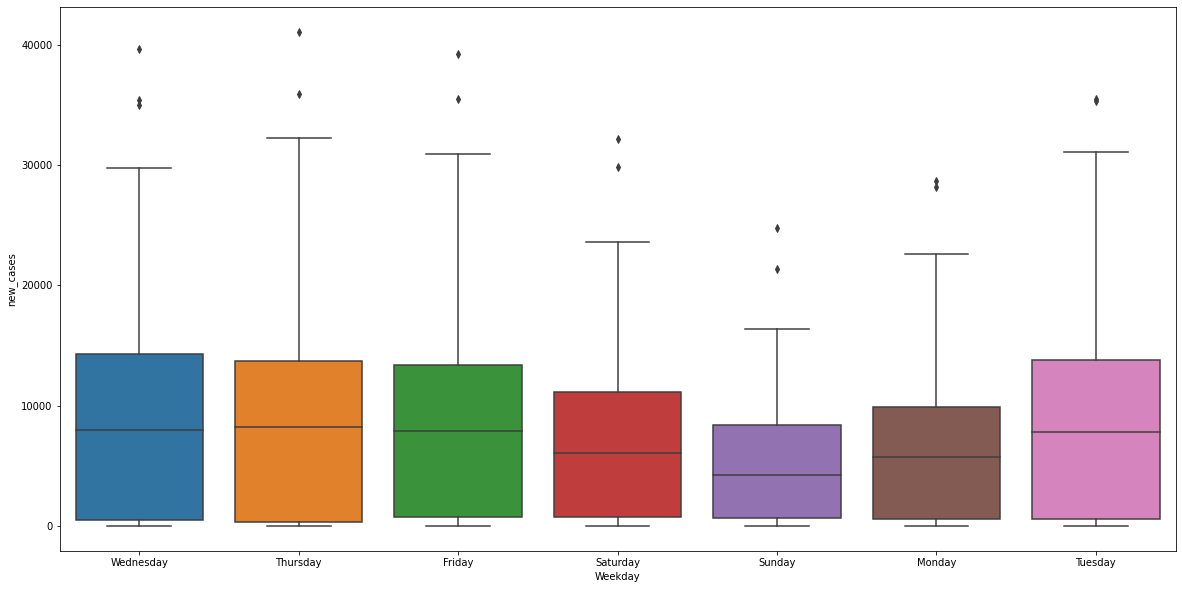

In [66]:
#Boxplot
fig, ax = plt.subplots(figsize=(20,10))
seaborn.boxplot(serie.Weekday, serie.new_cases, ax=ax)
plt.savefig("boxplot.png")

In [67]:
# Convertimos en array
serie = serie.drop(labels="Weekday", axis=1)
serie_array = serie.loc[:, 'new_cases'].values

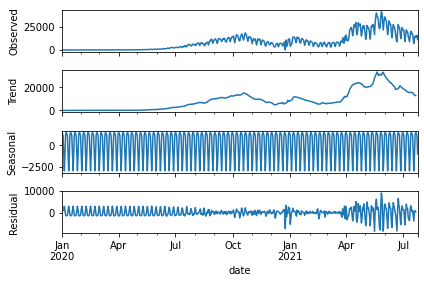

In [68]:
# Grafico descomposición:
result = seasonal_decompose(serie, model="additive")
fig = result.plot()
plt.savefig("Image.png")
plt.show(fig)

In [69]:
# Test KPSS para casos Covid:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, regression="c")
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(serie_array)

KPSS Statistic: 2.0603006477663013
p-value: 0.01
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



In [70]:
# Test ADF
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary') 

In [71]:
adf_test(serie_array)

ADF Statistic: -1.684904702311652
p-value: 0.4389063292013723
Critial Values:
   1%, -3.442273822587951
Critial Values:
   5%, -2.8667997388278583
Critial Values:
   10%, -2.5695712667942465
Result: The series is not stationary


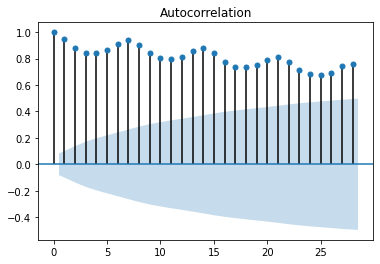

In [72]:
# Grafico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie)
plt.savefig("Image 2.f.png")
plt.show()

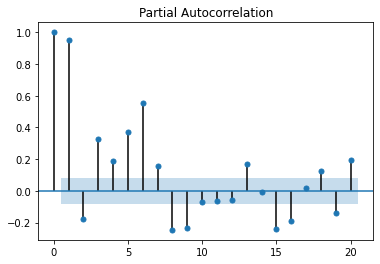

In [73]:
# Grafico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie, lags=20)
plt.savefig("Image 2.g.png")
plt.show()

In [74]:
# Ljung-Box test, lags= 20

sm.stats.acorr_ljungbox(serie, lags=20)

# P valor para todos los lags es meor a 0,05, por lo tanto rejecteamos la H0 -> Hay al menos una correlacion distinta de 0

(array([ 515.12741645,  960.25438301, 1371.90695043, 1779.24389819,
        2209.65152769, 2694.144011  , 3207.49859545, 3681.51160595,
        4093.10244912, 4469.49497793, 4838.71012504, 5226.36466341,
        5660.2959403 , 6117.20410773, 6532.82658642, 6887.09175799,
        7209.02848378, 7527.96238439, 7860.46070336, 8233.53405105]),
 array([4.86011427e-114, 3.04375799e-209, 3.67374898e-297, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [75]:
# Diferenciamos la serie:
serie_dif=serie
serie_dif["Diferences"] = None

In [76]:
for i in range(0,(serie_dif.shape[0]-1)):
  serie_dif.iloc[(i+1),1]=serie_dif.iloc[(i+1),0] - serie_dif.iloc[i,0]

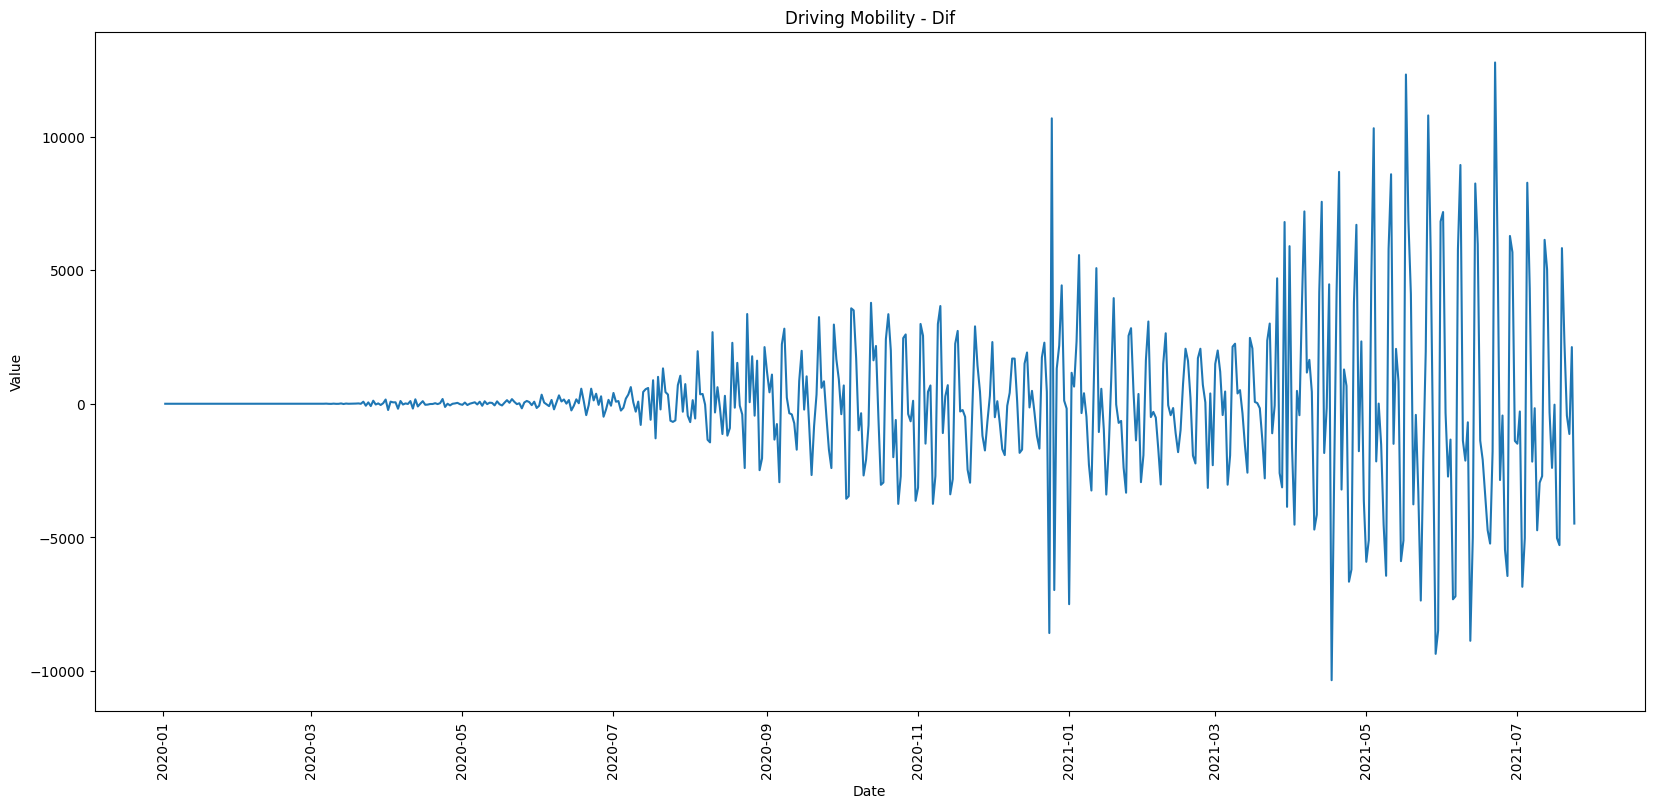

In [77]:
plot_data(serie_dif, x=serie_dif.index, y=serie_dif.Diferences, title='Driving Mobility - Dif')

In [78]:
# Convierto en array para realizar tests de estacionariedad
serie_dif_array = serie_dif.iloc[1:].Diferences

In [79]:
# Test KPSS
kpss_test(serie_dif_array)

KPSS Statistic: 0.06394069785745589
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



In [80]:
# Test ADF
adf_test(serie_dif_array)

ADF Statistic: -5.113741327781441
p-value: 1.315396007963365e-05
Critial Values:
   1%, -3.442273822587951
Critial Values:
   5%, -2.8667997388278583
Critial Values:
   10%, -2.5695712667942465
Result: The series is stationary


In [81]:
serie_dif=serie_dif["Diferences"].iloc[1:]
serie_dif=pd.DataFrame(serie_dif)

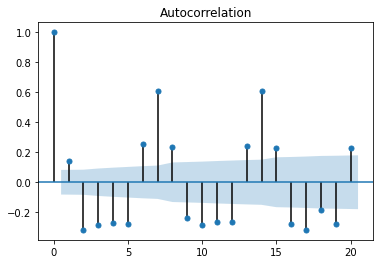

In [82]:
# Grafico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 4.b.png")
plt.show()

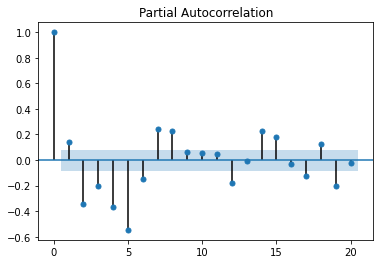

In [83]:
# Grafico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 4.c.png")
plt.show()

In [84]:
# Ljung-Box test con lag = 20
sm.stats.acorr_ljungbox(serie_dif.Diferences.tolist(), lags=20)

(array([  11.28829052,   69.29526523,  115.64079323,  157.60791386,
         202.82162565,  239.77137373,  456.18395055,  488.50342683,
         522.04244448,  568.52071122,  609.19174349,  649.70688722,
         684.25866993,  902.1336476 ,  932.36398713,  977.46283534,
        1036.68894699, 1056.68897861, 1101.99680385, 1133.21147972]),
 array([7.79974672e-004, 8.96859357e-016, 6.70076531e-025, 4.76322151e-033,
        7.07524662e-042, 6.28141118e-049, 2.08630497e-094, 2.05842614e-100,
        1.09265910e-106, 9.72932566e-116, 1.51369166e-123, 2.53462372e-131,
        7.96090416e-138, 1.50689447e-183, 4.16193446e-189, 7.48093164e-198,
        1.27238120e-209, 5.33745375e-213, 8.59683849e-222, 1.42219998e-227]))

In [85]:
# Corremos Auto Arima para elegir un modelo:
stepwise_fit = pm.auto_arima(serie.new_cases, start_p=1, start_q=1, max_p=10, max_q=10, m=7,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=10014.582, Time=1.67 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=10366.077, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=10160.115, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=10038.018, Time=1.18 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=10254.260, Time=0.73 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=10016.582, Time=2.24 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=10016.582, Time=3.85 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=10121.034, Time=1.43 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=6.89 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=10053.622, Time=0.94 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=10013.427, Time=2.32 sec
 ARIMA(2,1,1)(0,1,0)[7]             : AIC=inf, Time=1.29 sec
 ARIMA(2,1,1)(1,1,1)[7]             : AIC=10015.421, Time=3.00 sec
 ARIMA(2,1,1)(0,1,2)[7]             : AIC=10015.422, Time=4.85 sec
 ARIMA(2,1,1)(1,1,0)[7]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  571
Model:             SARIMAX(5, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -4997.450
Date:                           Sun, 01 Aug 2021   AIC                          10008.900
Time:                                   01:14:52   BIC                          10039.232
Sample:                                        0   HQIC                         10020.741
                                           - 571                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2873      0.020    -14.519      0.000      -0.326      -0.249
ar.L2         -0.2710      0.024    -11.335      0.000      -0.318      -0.224
ar.L3         -0.2338      0.027     -8.616      0.000      -0.287      -0.181
ar.L4         -0.1879      0.027     -6.875      0.000      -0.242      -0.134
ar.L5         -0.1350      0.027     -4.946      0.000      -0.189      -0.082
ma.S.L7       -0.8241      0.016    -50.232      0.000      -0.856      -0.792
sigma2       2.98e+06   8.84e+04     33.707      0.000    2.81e+06    3.15e+06
===================================================================================
Ljung-Box (Q):                      102.12   Jarque-Bera (JB):              1314.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             394.31   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
serie=serie.drop("Diferences", axis=1)

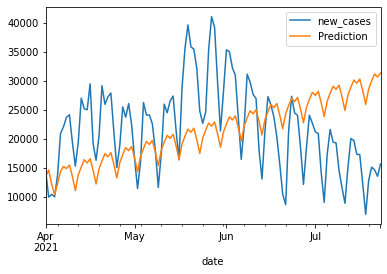

In [87]:
# Entrenamos, testeamos y validamos
train = serie.loc['2020-03-01':'2021-03-31']
test = serie.loc['2021-04-01':'2021-07-23']
stepwise_fit.fit(train)
future_forecast = stepwise_fit.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
comparison = pd.concat([test,future_forecast],axis=1)
comparison.plot()
plt.savefig("Model 1.a.png")

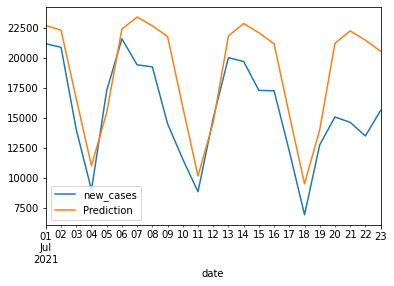

In [88]:
# Entrenamos, testeamos y validamos con otros periodos
train = serie.loc['2020-03-01':'2021-06-30']
test = serie.loc['2021-07-01':'2021-07-23']
stepwise_fit.fit(train)
future_forecast = stepwise_fit.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
comparison = pd.concat([test,future_forecast],axis=1)
comparison.plot()
plt.savefig("Model 1.b.png")

In [89]:
# Corremos otro auto arima ampliando la búsqeda:
stepwise_fit_2 = pm.auto_arima(serie, start_p=1, start_q=1, max_p=10, max_q=10, m=7,
                             start_P=0,max_P=10, seasonal=True, d=1, D=1, max_D=10, max_d=10, start_Q=1, max_Q=10, trace=True, with_intercept=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True,
                             maxiter=100)  # set to stepwise

stepwise_fit_2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7] intercept   : AIC=10016.468, Time=4.19 sec
 ARIMA(0,1,0)(0,1,0)[7] intercept   : AIC=10368.021, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7] intercept   : AIC=10162.115, Time=1.19 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=10039.976, Time=1.98 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=10366.077, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[7] intercept   : AIC=10256.120, Time=1.38 sec
 ARIMA(1,1,1)(1,1,1)[7] intercept   : AIC=10018.468, Time=4.25 sec
 ARIMA(1,1,1)(0,1,2)[7] intercept   : AIC=10018.468, Time=7.88 sec
 ARIMA(1,1,1)(1,1,0)[7] intercept   : AIC=10123.938, Time=1.62 sec
 ARIMA(1,1,1)(1,1,2)[7] intercept   : AIC=inf, Time=10.93 sec
 ARIMA(1,1,0)(0,1,1)[7] intercept   : AIC=10055.605, Time=1.25 sec
 ARIMA(2,1,1)(0,1,1)[7] intercept   : AIC=10015.305, Time=4.65 sec
 ARIMA(2,1,1)(0,1,0)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(2,1,1)(1,1,1)[7] intercept   : AIC=10017.299, Time=5.06 sec
 ARIMA(2,1,1)(0,1,2)[7] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  571
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 7)   Log Likelihood               -4989.933
Date:                           Sun, 01 Aug 2021   AIC                           9997.865
Time:                                   01:21:37   BIC                          10036.865
Sample:                                        0   HQIC                         10013.090
                                           - 571                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0085      0.036     -0.234      0.815      -0.080       0.063
ar.L1          2.4805      0.037     67.536      0.000       2.409       2.552
ar.L2         -2.0485      0.067    -30.779      0.000      -2.179      -1.918
ar.L3          0.5608      0.033     17.242      0.000       0.497       0.625
ma.L1         -2.8245      0.028    -99.586      0.000      -2.880      -2.769
ma.L2          2.7173      0.054     50.572      0.000       2.612       2.823
ma.L3         -0.8907      0.027    -33.300      0.000      -0.943      -0.838
ma.S.L7       -0.7930      0.018    -43.397      0.000      -0.829      -0.757
sigma2      2.878e+06   1.96e-08   1.47e+14      0.000    2.88e+06    2.88e+06
===================================================================================
Ljung-Box (Q):                       84.22   Jarque-Bera (JB):              1709.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             339.27   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.14e+30. Standard errors may be unstable.
"""

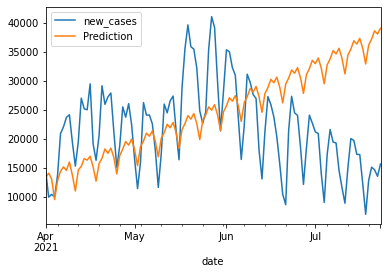

In [90]:
# Entrenamos, testeamos y validamos:
train = serie.loc['2020-03-01':'2021-03-31']
test = serie.loc['2021-04-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast = stepwise_fit_2.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
comparison = pd.concat([test,future_forecast],axis=1)
comparison.plot()
plt.savefig("Model 2.a.png")

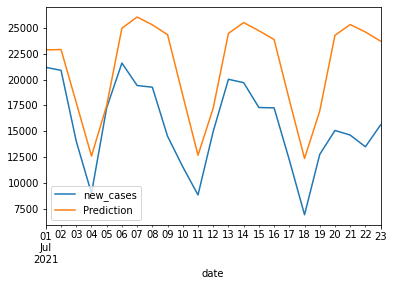

In [91]:
# Entrenamos, testeamos y validamos con otros periodos:
train = serie.loc['2020-03-01':'2021-06-30']
test = serie.loc['2021-07-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast = stepwise_fit_2.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
comparison = pd.concat([test,future_forecast],axis=1)
comparison.plot()
plt.savefig("Model 2.b.png")

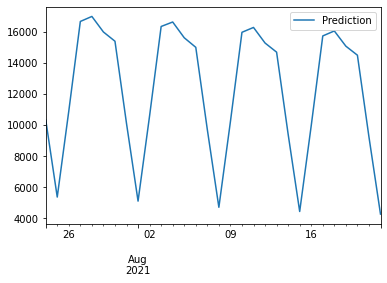

In [92]:
#Prediccion:

dates_predict = pd.date_range("2021-07-24","2021-08-22",freq='d')
train = serie.loc['2020-03-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast_2 = stepwise_fit_2.predict(n_periods=30)
future_forecast_2 = pd.DataFrame(future_forecast_2,index = dates_predict, columns=["Prediction"])
future_forecast_2.plot()
plt.savefig("Prediccion Casos Covid.png")

In [93]:
#EXportamos predicción:
future_forecast_2.to_csv("/content/sample_data/prediccion_casos.csv")